# An Analysis of Observed Properties of Fast Radio Bursts and Perytons
# by Casey Law, May 2015

### Inspired by Hippke et al. (2015), http://arxiv.org/pdf/1503.05245v2.pdf.

### First published on twitter at http://goo.gl/SpRiwy. Reformatted for reference in Dinah review, including numbered figures.

Primary motivating questions:
* Is there a significant "periodicity" in the dispersion measures of FRBs?
* Are there shared properties (particularly dispersion measure) between Perytons and FRBs?
* Are FRB arrival times located at integer second boundaries?

In [12]:
import numpy as n
import pylab as p
import os, glob
%matplotlib inline

## Load and generate Dispersion Measure distributions

* DM1 and DM2 are pulsar distributions
* DM3 is random with max of 1000 pc/cm3
* DM4 is random with mean/std equal to that of observed FRBs
* DMfrb is observed (10) FRBs considered in Hippke et al.
* DMper is observed (17) Perytons

In [13]:
cd ~/Dropbox

/Users/claw/Dropbox


In [14]:
# some pulsar DM values
dm1 = []; dm2 = []
f = open('psrtab1.txt','r')
for line in f.readlines():
    fields = line.split()
    if len(fields) == 10:
        dm1.append(float(fields[8]))
f = open('psrtab2.txt','r')
for line in f.readlines():
    fields = line.split()
    if len(fields) == 10:
        dm2.append(float(fields[8]))

dm1 = n.array(dm1); dm2 = n.array(dm2)

dmfrb = n.array([  375. ,   553.3,   557.4,   562.7,   723. ,   746. ,   788. ,     790. ,   944.4,  1103.6])  # FRB DMs
dmper = n.array([344, 400, 382, 217, 213, 396, 421, 357, 393, 374, 278, 402, 400, 350, 350, 350, 375])      # Peryton DMs

# random values
dmmax = max(dm1.max(), dm2.max())
dm3 = n.random.rand(1000)*dmmax
dm4 = n.random.normal(dmfrb.mean(), dmfrb.std(), 1000)

In [15]:
print len(dm1), len(dm2), len(dm3), len(dm4), len(dmper), len(dmfrb)

180 263 1000 1000 17 10


## Define useful functions for calculating random DM distributions and their cumulative distribution properties

### Here we use a Rayleigh test (in "inttrial" function) to calculate significance of "periodicity" or integer multiples

In [16]:
def cdist(dms, ax=False):
    """ Plot cumulative distribution
    """
    
    count = len(dms)
    cfrac = n.arange(1,count+1)/float(count)
    dms.sort()
    pl = p.plot(dms, cfrac,'.')
    if ax:
        pl = p.xlabel('DM (pc/cm3)')
        pl = p.ylabel('Cumulative fraction')
    else:  # hide stuff for tight plotting
        pl = p.xticks([],[])
        pl = p.yticks([],[])

In [17]:
def inttrial(dms, dmmin=0, dmmax=0):
    """ For a given sample of DMs, find residual for a set of assumed fundamental integer DM basis
    """

    modulo = lambda dm: (n.mod(dms, dm)/dm).mean()
    ray = lambda dm: n.sqrt(n.sin(2*n.pi*dms/dm).mean()**2 + n.cos(2*n.pi*dms/dm).mean()**2)
    ray2 = lambda dm: 1./len(dms) * ( (n.sin(2*n.pi*dms/dm).sum())**2 + (n.cos(2*n.pi*dms/dm).sum())**2 )  # includes scaling with number of events

    if dmmin == 0:
        dmmin = dms.max()/float(len(dms))
    if dmmax == 0:
        dmmax = dms.max()/2
    stat = []
    grid = n.arange(dmmin,dmmax,0.5)
    for dm in grid:
#        stat.append(modulo(dm, dms))
        stat.append(ray(dm))
    return n.array(grid), n.array(stat)

def plottrial((grid, resid)):
    pl = p.plot(grid, resid, '.')
    pl = p.xlabel('Assumed Fundamental DM (pc/cm3)')
    pl = p.ylabel('Statistic')

In [18]:
def sample(dms, ntrials, size=10, thresh=0, dmmin=0, dmmax=0):
    """ Sample dms ntrials times with size values and calculate inttrial distribution.
    Minimum of inttrial distribution saved.
    """

    minresid = []
    dmresid = []
    lowesttrial = []; lowestdms = []
    for i in range(ntrials):
        sampleints = n.random.random_integers(0, len(dms)-1, size)
        dmsample = dms.take(sampleints)
        grid, resid = inttrial(dmsample, dmmin=dmmin, dmmax=dmmax)
#        minresid.append(resid.min())
#        dmresid.append(grid[n.where(resid == resid.min())])
#        if (thresh > 0) and (resid.min() < thresh):
        minresid.append(resid.max())
        dmresid.append(grid[n.where(resid == resid.max())])
        if (thresh > 0) and (resid.max() > thresh):
            lowesttrial.append((grid, resid))
            lowestdms.append(dmsample)
    if thresh > 0:
        print 'Found %d out of %d. Occurrence rate of %.3f beyond threshold Rayleigh test statistic value.' % (len(lowesttrial), ntrials, len(lowesttrial)/float(ntrials))
    return n.array(dmresid), n.array(minresid), lowesttrial, lowestdms

## Visualize observed and simulated DM cumulative distributions

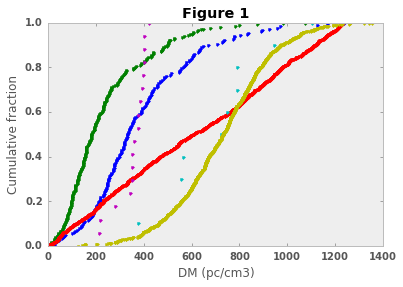

In [19]:
# cumulative distributions of all four full samples
cdist(dm1, ax=True), cdist(dm2, ax=True), cdist(dm3, ax=True), cdist(dmfrb, ax=True), cdist(dmper, ax=True), cdist(dm4, ax=True)
p.title("Figure 1")

## What is the value of the Rayleigh test statistic for each of the distributions above in their entirety?

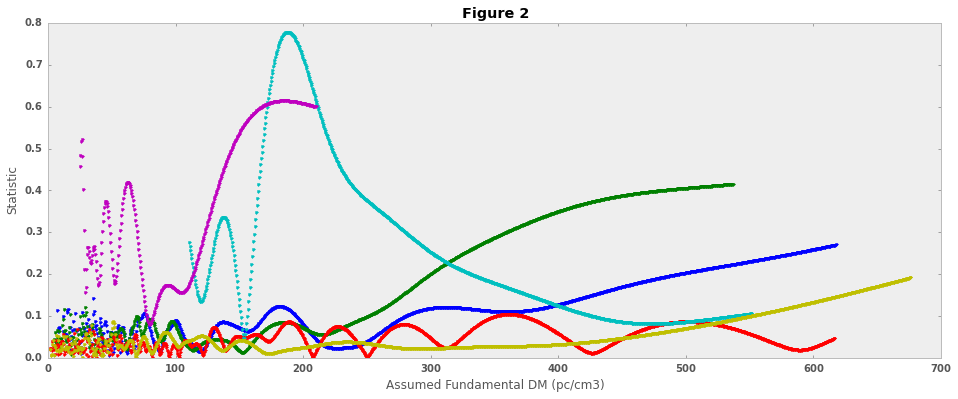

In [20]:
# fundamental DM trials analysis for all four full samples
p.figure(figsize=(16,6))
plottrial(inttrial(dm1))
plottrial(inttrial(dm2))
plottrial(inttrial(dm3))
plottrial(inttrial(dmfrb))
plottrial(inttrial(dmper))
plottrial(inttrial(dm4))
p.title("Figure 2")

## Using published FRB DM distribution, calculate Rayleigh test statistic

In [21]:
grid, resid = inttrial(dmfrb)
thresh = resid.max()
dmpeak = grid[n.where(resid == thresh)]
print 'FRBs Rayleigh test value:', thresh, dmpeak[0]
grid, resid = inttrial(dmper)
print 'Perytons Rayleigh test value:', resid.max(), grid[n.where(resid == resid.max())][0]

FRBs Rayleigh test value: 0.779623910652 187.86
Perytons Rayleigh test value: 0.615273887653 184.764705882


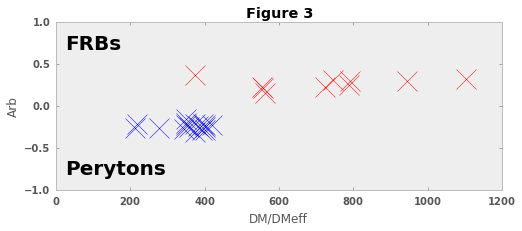

In [22]:
p.figure(figsize=(8,3))
yval = n.random.normal(-0.25, 0.05, len(dmper))
p.plot(dmper, yval, 'bx', markersize=20)
p.text(30, -0.75, "Perytons", verticalalignment='center', horizontalalignment='left', fontsize=20)
yval = n.random.normal(0.25, 0.05, len(dmfrb))
p.plot(dmfrb, yval, 'rx', markersize=20)
p.text(30, 0.75, "FRBs", verticalalignment='center', horizontalalignment='left', fontsize=20)
p.axis( (0, 1200, -1, 1) )
p.xlabel('DM/DMeff')
p.ylabel('Arb')
p.title("Figure 3")

## How often does this Rayleigh test value occur in a random samples of 10 events (as for true FRB sample)?

In [23]:
dmresid, resid, lowesttrial, lowestdms = sample(dm4, 1000, size=10, thresh=thresh)

Found 15 out of 1000. Occurrence rate of 0.015 beyond threshold Rayleigh test statistic value.


## How common is it to have a very small residual DM, if assuming a fundamental DM?

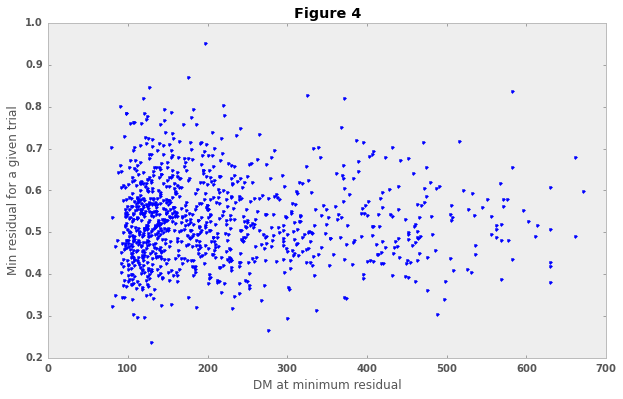

In [24]:
p.figure(figsize=(10,6))
p.plot(dmresid,resid,'.')
p.xlabel('DM at minimum residual')
p.ylabel('Min residual for a given trial')
#p.ylim((0,1))
p.title("Figure 4")

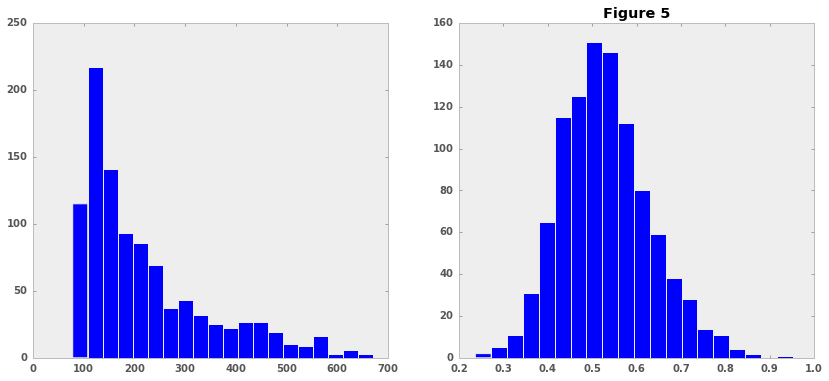

In [25]:
p.figure(figsize=(14,6))
p.subplot(121)
h1 = p.hist(dmresid, bins=20)
p.subplot(122)
h2 = p.hist(resid, bins=20)
p.title("Figure 5")

## What is the Rayleigh test statistic spectrum for these subsamples with significant fundamental DMs?

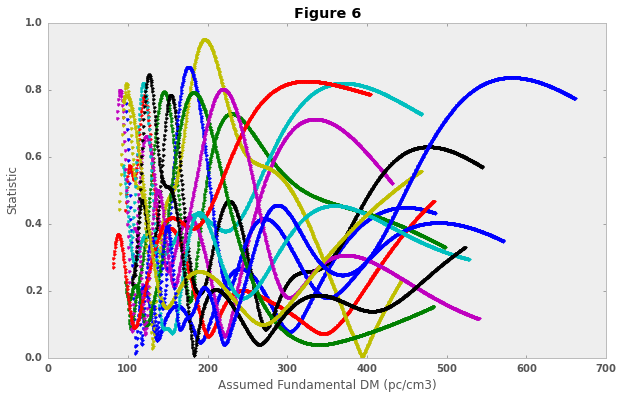

In [26]:
p.figure(figsize=(10,6))
for i in range(len(lowesttrial)):
    stuff = plottrial(lowesttrial[i])
#p.ylim((0,1))
p.title("Figure 6")

## What is the cumulative DM distribution for these simulated samples with "significant" periodicities?

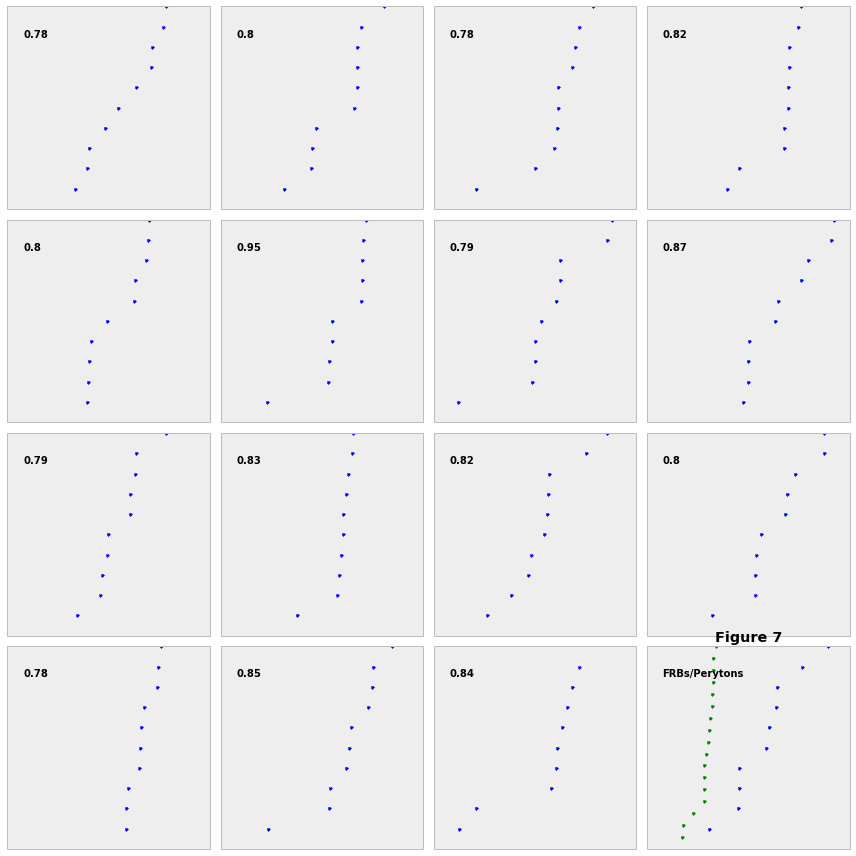

In [27]:
p.figure(figsize=(12,12))
gridext = n.ceil(n.sqrt(len(lowestdms)+1))
for i in range(1,len(lowestdms)+1):
    p.subplot(gridext,gridext,i)
    cdist(lowestdms[i-1])
    p.axis( (0,dmmax, 0, 1) )
    p.text(100,0.85, n.round(lowesttrial[i-1][1].max(),2))
# plot FRB and Peryton DMs
i+=1
p.subplot(gridext,gridext,i)
p.axis( (0, dmmax, 0, 1) )
cdist(dmfrb)
p.text(100,0.85, 'FRBs/Perytons')
cdist(dmper)
p.tight_layout()
p.title("Figure 7")